In [1]:
import Zygote: @ignore_derivatives
import Optimisers
import Zygote
import Plots
import CSV
import Random
import GLM
using Lux
using DataFrames
using ComponentArrays
using SciMLSensitivity
using DifferentialEquations
using Printf
using JLD2


include("../../../DCM/src/lib/population.jl");
include("../../../DCM/src/lib/model.jl");
include("../../../DCM/src/lib/error.jl");
include("../../../DCM/src/lib/objectives.jl");
include("../../../DCM/src/lib/callbacks.jl");
include("../../../DCM/src/lib/latent_encoder_decoder.jl");
include("../../../DCM/src/lib/lux.helpers.jl");

## Data preparation

In [2]:
# Read Data
file = "../../data/fviii_sim.csv"
df = CSV.read(file, DataFrame)

# One dataframe per patient
df_group = groupby(df, :id);

In [3]:
# Create population
function create_population(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        𝐈 = Matrix{Float32}(group[group.mdv .== 1, [:t, :amt, :rate, :duration]])
        callback = generate_dosing_callback(𝐈)
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), callback; id = group.id[1])
    end
    return Population(indvs);
end
population = create_population(df_group);

## Training

### Functions

In [17]:
latent_dim = 2

encoder = Chain(
    Normalize([70, 40]),
    Dense(size(population.x, 1), 16, swish),
    Dense(16, 8, swish),
    Dense(8, latent_dim * 2)
)

node = Chain(
    Dense(latent_dim, 12, tanh),
    Dense(12, 12),
    Dense(12, latent_dim)
)

decoder = Chain(
    Normalize(fill(100, latent_dim)),
    Dense(latent_dim, 16, swish),
    Dense(16, 1, softplus)
);

# Loss function
function obj(model, population, p, st)
    ŷ = forward_adjoint(model, population, p, st)
    dif = reduce(vcat, population.y - ŷ)
    return sum(abs2, dif)
end;

function mae(model, population, p, st)
    ŷ = forward_adjoint(model, population, p, st)
    dif = reduce(vcat, population.y - ŷ)
    return sum(abs, dif)/length(dif)
end;

function train_model(model, p, st, population_train, num_epochs; population_test=nothing, verbose=true, patience=30, tol=0.01)
    global opt_state
    losses = []
    losses_test = []
    times = []

    count = 0
    for epoch in 1:num_epochs
        elapsed_time = @elapsed begin
            loss, back = Zygote.pullback(p_ -> obj(model, population_train, p_, st), p)
            grad = first(back(1))
            opt_state, p = Optimisers.update(opt_state, p, grad)
        end
        push!(times, elapsed_time)

        push!(losses, loss)
        if population_test !== nothing
            push!(losses_test, obj(model, population_test, p, st))
        end

        if (epoch == 1 || epoch % 50 == 0) && verbose
            println("Epoch $epoch, loss = $loss")
        end

        if epoch == 300      
            Optimisers.adjust!(opt_state, 0.001)
        end

        # Early stopping on percentual change of test loss. The test population is needed
        if population_test !== nothing
            if (epoch > 1) && ((losses_test[end-1] - losses_test[end])/losses_test[end-1] < tol)
                count += 1
                if count == patience
                    println("Early stopped. Percentual test loss did not improve at least $tol for $patience epochs. Trained for $epoch epochs\n")
                    verbose && println("\nMean ± std training time per epoch: $(@sprintf("%.2e", mean(times))) ± $(@sprintf("%.2e", std(times))) seconds")
                    return p, losses, losses_test
                end
            else 
                count = 0
            end
        end
    end
    verbose && println("\nMean ± std training time per epoch: $(@sprintf("%.2e", mean(times))) ± $(@sprintf("%.2e", std(times))) seconds")
    return p, losses, losses_test
end


# Plot predictions vs real values
function plot_predictions_real(model, p, st, population; threshold=0.2)
    real = reduce(vcat, population.y)
    predicted = reduce(vcat, forward_adjoint(model, population, p, st))
    plt = Plots.scatter(
        real,
        predicted,
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        legend=false
    )

    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))

    accuracy = count(x -> x < threshold, abs.((real - predicted)) ./ (real .+ 1e-6))/length(real)
    max_value = ceil(maximum(vcat(real, predicted)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        #ribbon = [0, max_value] .* threshold,
        fillalpha = 0.2,
        #color = "red",
        linestyle = :dash,
        
        )

    regression = GLM.predict(lr, DataFrame(X=[0, max_value]))
    rsquared = GLM.r2(lr)

    Plots.plot!(plt, 
        [0, max_value], 
        regression,
        color = "blue",
        title = "R2 = $(@sprintf("%.2f", rsquared))"
        )
    display(plt)
end

function training_metrics(model, p, st, population)
    #MAE
    mean_absolute_error = mae(model, population, p, st)

    #R2
    real = reduce(vcat, population.y)
    predicted = reduce(vcat, forward_adjoint(model, population, p, st))
    lr = GLM.lm(GLM.@formula(y ~ X), DataFrame(X=Float64.(real), y=Float64.(predicted)))
    rsquared = GLM.r2(lr)

    return mean_absolute_error, rsquared
end

# Plot predictions vs real values
function plot_train_test_real(model, population_train, population_test)

    plt = Plots.scatter(
        reduce(vcat, population_train.y),
        reduce(vcat, forward_adjoint(model, population_train, p, st)),
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:blue,
        size=(600,400),
        label="Train"
    )

    Plots.scatter!(
        reduce(vcat, population_test.y),
        reduce(vcat, forward_adjoint(model, population_test, p, st)),
        xlabel="True",
        ylabel="Predicted",
        markersize=2,
        markercolor=:red,
        size=(600,400),
        label="Test"
    )
    max_value = ceil(maximum(reduce(vcat, population_train.y)))
    Plots.plot!(plt, 
        [0, max_value], 
        [0, max_value],
        linestyle = :dash,
        color=:black,
        label=nothing
        )
    display(plt)
end


plot_train_test_real (generic function with 1 method)

### Train using all the population

Epoch 1, loss = 942548.2
Epoch 50, loss = 213170.36
Epoch 100, loss = 136648.22
Epoch 150, loss = 91447.516
Epoch 200, loss = 52612.47
Epoch 250, loss = 50628.16

Mean ± std training time per epoch: 2.08e+00 ± 6.36e-01 seconds

Final MSE: 50628.16
Final MAE: 4.7852883
Final R2: 0.9024543303593462


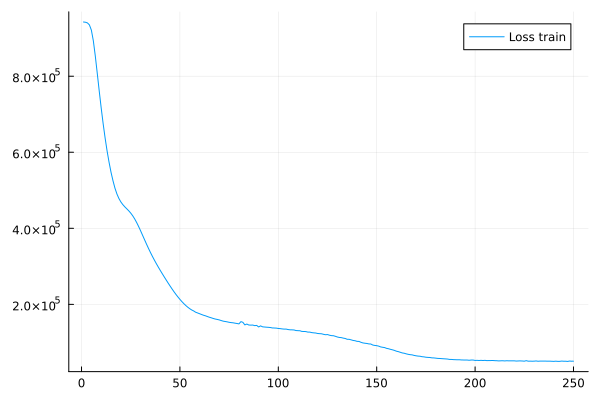

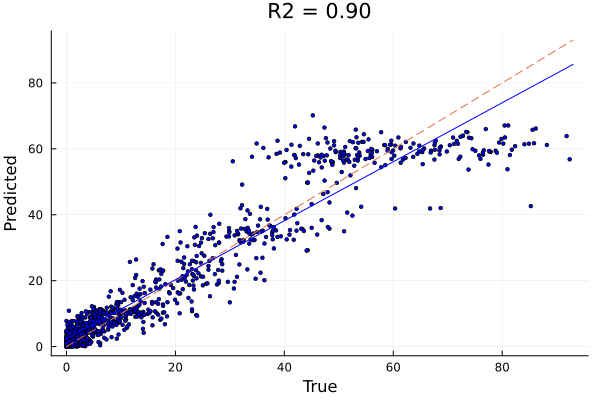

In [25]:
model = LatentEncoderDecoder(encoder, node, decoder)
ps, st = Lux.setup(Random.default_rng(), model)
p = (weights = ps,)
opt = Optimisers.Adam(1e-2)
opt_state = Optimisers.setup(opt, p);

p, losses, _ = train_model(model, p, st, population, 250; population_test=nothing)

println()
final_mse = losses[end]
println("Final MSE: $final_mse")

final_mae, final_r2 = training_metrics(model, p, st, population)

println("Final MAE: $final_mae")
println("Final R2: $final_r2")

plt = Plots.plot(losses, label = "Loss train")
display(plt)

plot_predictions_real(model, p, st, population)

### Save/load model

In [26]:
# Save model
#jldsave("models/mymodel-fviii-5.jld2"; p, model, st)

In [128]:
# Load model
# mymodel = JLD2.load("mymodel.jld2")
# model = mymodel["model"]
# p = mymodel["p"]
# st = mymodel["st"]

### Train using test split

Epoch 1, loss = 667813.1
Epoch 50, loss = 160105.75
Epoch 100, loss = 93033.625
Epoch 150, loss = 57500.812
Epoch 200, loss = 40627.195
Epoch 250, loss = 37696.844
Early stopped. Percentual test loss did not improve at least 0.01 for 30 epochs. Trained for 262 epochs



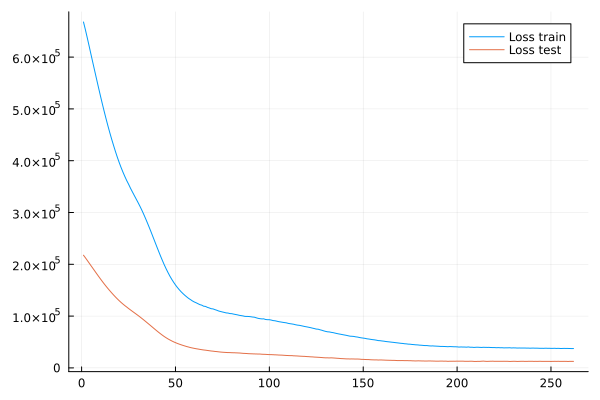


Final MAE train: 4.627651
Final R2 train: 0.9033040115592259

Final MAE test: 5.0692143
Final R2 test: 0.9016946025661842


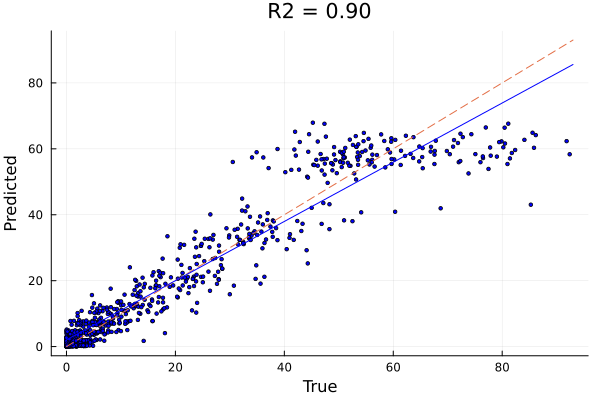

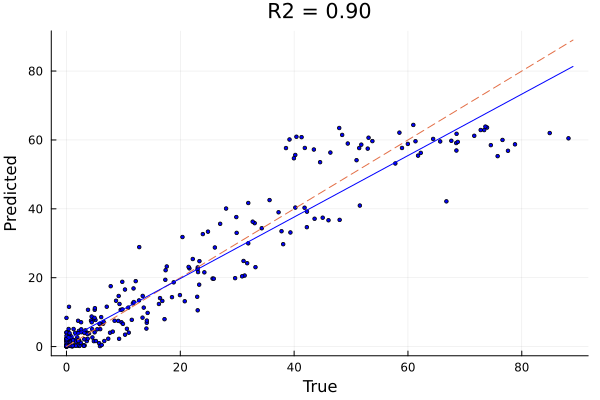

In [18]:
# Get random patients for train and test
Random.seed!(1)
ids = 1:length(df_group)
test_ids = sample(ids, div(length(ids), 4), replace = false)
train_ids = setdiff(ids, test_ids)

# Create train and test populations
population_test = create_population(df_group[test_ids]);
population_train = create_population(df_group[train_ids]);

model = LatentEncoderDecoder(encoder, node, decoder)
ps, st = Lux.setup(Random.default_rng(), model)
p = (weights = ps,)
opt = Optimisers.Adam(1e-2)
opt_state = Optimisers.setup(opt, p);

p, losses, losses_test = train_model(model, p, st, population_train, 300; population_test=population_test, patience=30, tol=0.01)

plt = Plots.plot(losses, label = "Loss train")
Plots.plot!(plt, losses_test, label = "Loss test")
display(plt)

println()
final_mae_train, final_r2_train = training_metrics(model, p, st, population_train)
println("Final MAE train: $final_mae_train")
println("Final R2 train: $final_r2_train")
println()
final_mae_test, final_r2_test = training_metrics(model, p, st, population_test)
println("Final MAE test: $final_mae_test")
println("Final R2 test: $final_r2_test")

plot_predictions_real(model, p, st, population_train)
plot_predictions_real(model, p, st, population_test)

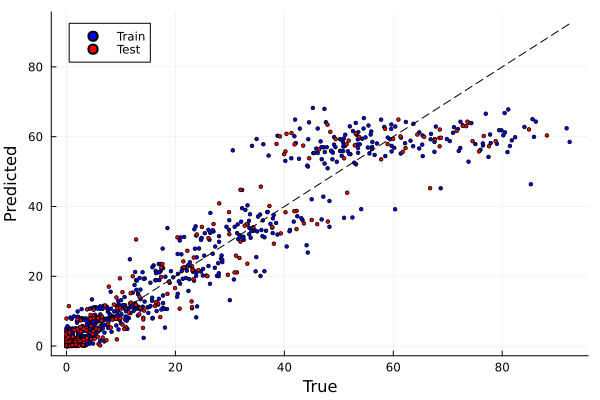

In [16]:
plot_train_test_real(model, population_train, population_test)

### K folds training

In [12]:
# Get random patients for train and test
folds = 7
ids = 1:length(df_group)

l_mae_train = []
l_mae_test = []
l_r2_train = []
l_r2_test = []

for i in 1:folds
    println("Fold $i/$folds")
    test_ids = sample(ids, div(length(ids), 4), replace = false)
    train_ids = setdiff(ids, test_ids)

    # Create train and test populations
    population_test = create_population(df_group[test_ids]);
    population_train = create_population(df_group[train_ids]);

    model = LatentEncoderDecoder(encoder, node, decoder)
    ps, st = Lux.setup(Random.default_rng(), model)
    p = (weights = ps,)
    opt = Optimisers.Adam(1e-2)
    opt_state = Optimisers.setup(opt, p);

    p, _, _ = train_model(model, p, st, population_train, 300; population_test = population_test, verbose=false, patience=30, tol=0.01)

    final_mae_train, final_r2_train = training_metrics(model, p, st, population_train)
    push!(l_mae_train, final_mae_train)
    push!(l_r2_train, final_r2_train)

    final_mae_test, final_r2_test = training_metrics(model, p, st, population_test)
    push!(l_mae_test, final_mae_test)
    push!(l_r2_test, final_r2_test)
end

# Remove largest and smallest values from list. To remove extreme cases that can happen due to initialization
l_mae_train = filter(x -> x != maximum(l_mae_train) && x != minimum(l_mae_train), l_mae_train)
l_mae_test = filter(x -> x != maximum(l_mae_test) && x != minimum(l_mae_test), l_mae_test)
l_r2_train = filter(x -> x != maximum(l_r2_train) && x != minimum(l_r2_train), l_r2_train)
l_r2_test = filter(x -> x != maximum(l_r2_test) && x != minimum(l_r2_test), l_r2_test)

println()
println("Mean ± std MAE train: $(@sprintf("%.2f", mean(l_mae_train))) ± $(@sprintf("%.2f", std(l_mae_train)))")
println("Mean ± std MAE test: $(@sprintf("%.2f", mean(l_mae_test))) ± $(@sprintf("%.2f", std(l_mae_test)))")
println()
println("Mean ± std R2 train: $(@sprintf("%.2f", mean(l_r2_train))) ± $(@sprintf("%.2f", std(l_r2_train)))")
println("Mean ± std R2 test: $(@sprintf("%.2f", mean(l_r2_test))) ± $(@sprintf("%.2f", std(l_r2_test)))")

Fold 1/7
Fold 2/7
Fold 3/7
Fold 4/7
Fold 5/7
Fold 6/7
Fold 7/7

Mean ± std MAE train: 1.13 ± 0.06
Mean ± std MAE test: 1.51 ± 0.14

Mean ± std R2 train: 0.81 ± 0.02
Mean ± std R2 test: 0.66 ± 0.08


## Predict

### Functions

In [88]:
# The forward adjoint method is only defined for populations. Create one for individuals
function forward_ed(model, individual, p, st; kwargs...)
    popind = Population([individual])
    predicted = forward_adjoint(model, popind, p, st; kwargs...)[1]
end

# Predict a single individual. The predicted values are only saved for the individual.t times
function predict_individual(individual, p; plot_predictions=false)
    
    predicted = forward_ed(model, individual, p, st)

    if plot_predictions
        plt = Plots.plot(individual.t, predicted, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        display(plt)
    end
    return predicted
end

function predict_real_individual(individual, p; max_time = 72, plot_predictions = false, plot_true_labels = false)

    time_real = individual.t
    real_y = individual.y

    time = collect(0:0.1:(max_time));
    subject = Individual(individual.x, Float32.(time), Float32.(zeros(length(time))), individual.callback);

    predicted = forward_ed(model, subject, p, st)

    if plot_predictions
        plt = Plots.plot(subject.t, predicted, 
                    label="Predicted", xlabel="Time", ylabel="Concentration",
                    color = :black,
                    size=(600,300))
        if plot_true_labels
            Plots.scatter!(plt, time_real, real_y, label="Real", color=:blue)
        end
        display(plt)
    end
    return predicted, time
end


# Create Intervention Matrix from [(time1, dose1), (time2, dose2), ...] list
function create_intervention_matrix(dose_list; duration = 120)
    if length(dose_list) == 0 return end
    M = []
    for (t, d) in dose_list
        row = [t, d, d * duration, 1/duration]
        push!(M, row)
    end

    # Convert the array of arrays to a matrix
    M = hcat(M...)
    M = M'
end;


### Predict real individual from population with real labels

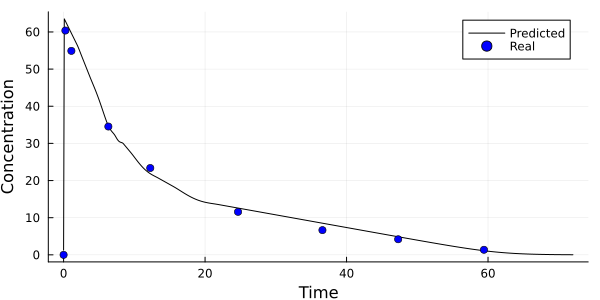

In [95]:
predict_real_individual(population[2], p; max_time = 72, plot_predictions = true, plot_true_labels = true);

### Predict single individual without labels

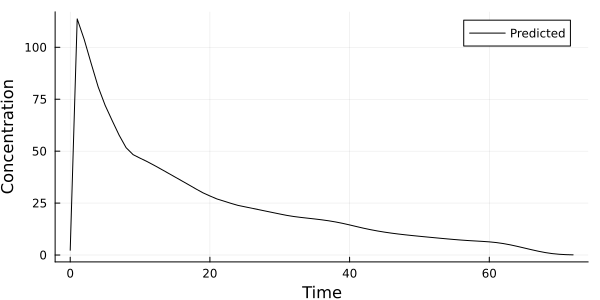

In [81]:
t = collect(0:1:72)
x = [70.0, 40.0]

doses = [(0,3500)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)

subject = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), callback)
#subject = population[8]

predict_individual(subject, p; plot_predictions=true);